In [12]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.util.remote import Remote

from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.operators.sampling.rnd import FloatRandomSampling,IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
import math
import copy
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler
from keras.layers import Dropout

In [13]:
# Criptomoedas que vamos escolher para nosso portifólio
cryptos = [
    'BTC-USD', 'ETH-USD','LTC-USD', 'ADA-USD',
    'DOT-USD', 'LINK-USD','SOL-USD',
    'TRX-USD'
]

In [14]:
data_visual = {}
for crypto in cryptos:
    data_visual[crypto] = pd.read_csv(f"{crypto}.csv", index_col='Date')
    data_visual[crypto] = data_visual[crypto][~data_visual[crypto].index.duplicated(keep='first')]

In [15]:
data_visual['BTC-USD'].dropna()

,Crypto_Return_Today,exp_value
Date,,
2023-04-28,-0.004786,0.001843
2023-04-29,-0.003007,0.004491
2023-04-30,0.000796,0.004026
2023-05-01,-0.039627,0.002075
2023-05-02,0.020906,0.002470
...,...,...
2024-10-16,0.008470,0.003743
2024-10-17,-0.003218,-0.000829
2024-10-18,0.014719,0.006106


In [16]:
df = data_visual['ETH-USD']
df['ae'] = df['exp_value'] - df['Crypto_Return_Today']
df['ae'] = abs(df['ae'])
df['mae'] = df['ae'].rolling(window = 50).mean()

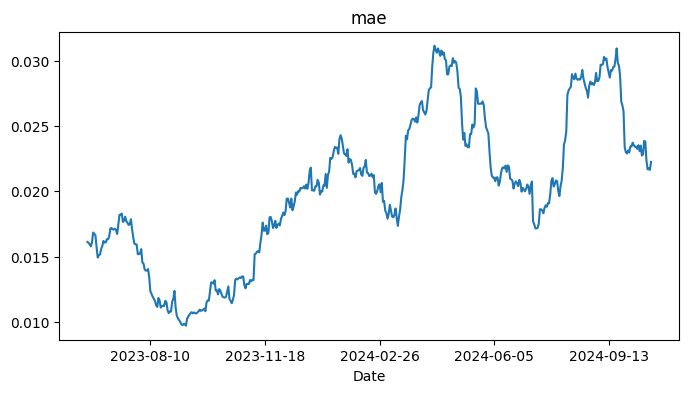

In [17]:
from matplotlib import pyplot as plt
df['mae'].plot(kind='line', figsize=(8, 4), title='mae')
plt.gca().spines[['top', 'right']].set_visible(True)

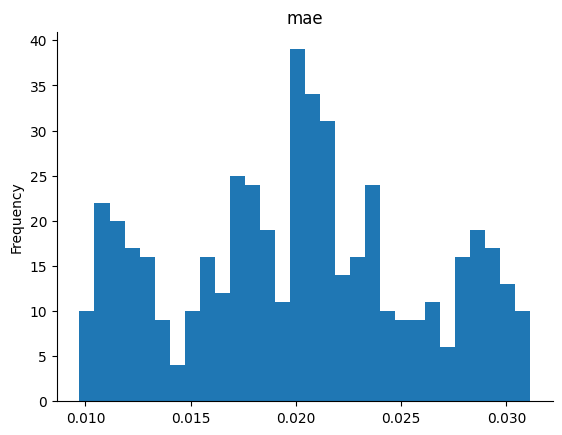

In [18]:
from matplotlib import pyplot as plt
df['mae'].plot(kind='hist', bins=30, title='mae')
plt.gca().spines[['top', 'right',]].set_visible(False)

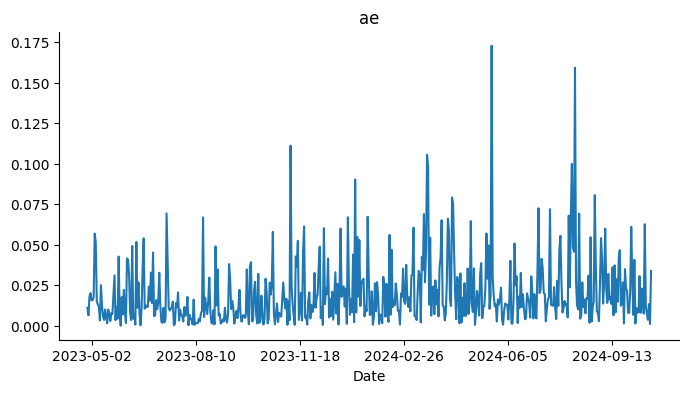

In [19]:
from matplotlib import pyplot as plt
df['ae'].plot(kind='line', figsize=(8, 4), title='ae')
plt.gca().spines[['top', 'right']].set_visible(False)

### **Vamos criar data2**
#### Este será um dicionário que lê os csv's salvos e os armazena para cada criptomoeda

In [20]:
data2 = {}
for crypto in cryptos:
    data2[crypto] = pd.read_csv(f"{crypto}.csv", index_col='Date')
    data2[crypto] = data2[crypto][~data2[crypto].index.duplicated(keep='first')]
    #data_complete[crypto] = pd.read_csv(f"{crypto}.csv")

In [21]:
for crypto in cryptos:
    print(len(data2[crypto]))
    data2[crypto] = data2[crypto]


2983
2538
2983
2538
1523
2538
1655
2538


In [22]:
data2['BTC-USD']

,Crypto_Return_Today,exp_value
Date,,
2016-08-21,-0.001085,NaN
2016-08-22,0.009318,NaN
2016-08-23,-0.005736,NaN
2016-08-24,-0.005552,NaN
2016-08-25,-0.004178,NaN
...,...,...
2024-10-16,0.008470,0.003743
2024-10-17,-0.003218,-0.000829
2024-10-18,0.014719,0.006106


### **Vamos criar data_mus**
#### Este será um DataFrame que cada linha representa uma sample, e cada coluna representa o valor esperado de um dos ativos de nosso portifólio.

In [23]:
data_mus = pd.DataFrame()
for crypto in cryptos:
    data_mus = pd.merge(data_mus, data2[crypto]['exp_value'], left_index=True, right_index=True, how='outer', suffixes=('', crypto))
    data_mus = data_mus.rename(columns={f'exp_value{crypto}': crypto})

In [24]:
#data_mus.fillna(0, inplace=True)
data_mus = data_mus.rename(columns={'exp_value': 'BTC-USD'})
data_mus

,BTC-USD,ETH-USD,LTC-USD,ADA-USD,DOT-USD,LINK-USD,SOL-USD,TRX-USD
Date,,,,,,,,
2016-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-10-16,0.003743,0.009319,0.009478,0.000991,0.002552,0.002543,0.005475,0.004135
2024-10-17,-0.000829,0.001030,-0.003648,0.000392,0.000020,-0.000362,0.002275,0.001567
2024-10-18,0.006106,0.000691,0.003061,0.002838,0.004308,0.003416,0.000949,0.001356


### **Vamos criar data_reals**
#### Este será um DataFrame que cada linha representa uma sample, e cada coluna representa o valor real de um dos ativos de nosso portifólio.

In [25]:
data_reals = pd.DataFrame()
for crypto in cryptos:
    data_reals = pd.merge(data_reals, data2[crypto]['Crypto_Return_Today'], left_index=True, right_index=True, how='outer', suffixes=('', crypto))
    data_reals = data_reals.rename(columns={f'Crypto_Return_Today{crypto}': crypto})

In [26]:
data_reals = data_reals.rename(columns={'Crypto_Return_Today': 'BTC-USD'})
data_reals

,BTC-USD,ETH-USD,LTC-USD,ADA-USD,DOT-USD,LINK-USD,SOL-USD,TRX-USD
Date,,,,,,,,
2016-08-21,-0.001085,NaN,-0.001200,NaN,NaN,NaN,NaN,NaN
2016-08-22,0.009318,NaN,0.010953,NaN,NaN,NaN,NaN,NaN
2016-08-23,-0.005736,NaN,0.070155,NaN,NaN,NaN,NaN,NaN
2016-08-24,-0.005552,NaN,-0.018953,NaN,NaN,NaN,NaN,NaN
2016-08-25,-0.004178,NaN,-0.014212,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-10-16,0.008470,0.001948,-0.011386,-0.016882,-0.019825,-0.017466,-0.003149,0.007900
2024-10-17,-0.003218,-0.002653,0.037386,-0.027303,-0.030039,-0.019495,-0.025758,-0.004309
2024-10-18,0.014719,0.014005,0.005285,0.022151,0.027627,0.040463,0.030485,-0.005173


### **Vamos criar  mus e reals**
#### mus será um dicionário, cujas chaves são as datas que compõe o index de data_mus, e cada item é um numpy array de 8 elementos (representando as criptomoedas) e 1 ultimo elemento representando o RFR
#### reals será um dicionário cujas chaves são as datas que compõe do index de data_mus, e cada item é um np array de 8 elementos (representando as criptomoedas) e 1 ultimo elemento representando o RFR
##### *Importante!* - Vamos fazer de tal modo que, para os arrays com valores NaN, nós removemos ele do portifólio

In [27]:
covs = {}
mus = {}
reals = {}

for i in range(100, data_mus.shape[0], 1):
    if(i < 200):
        df1 = data_reals[0:i] # Tabela que vai me ajudar a criar a matriz de covariância
        df2 = data_mus[i:i+1] # de onde vou coletar o previsto
        df3 = data_reals[i:i+1] # de onde vou coletar o real
    else:
        df1 = data_reals[i-200:i] # Tabela que vai me ajudar a criar a matriz de covariância
        df2 = data_mus[i:i+1]
        df3 = data_reals[i:i+1] # de onde vou coletar o real
        
    cols_with_nan_in_df2 = df2.isna().any()
    # Remover do df1 as colunas que possuem NaN em df2
    df1_cleaned = df1.drop(columns=df1.columns[cols_with_nan_in_df2])
    df2_cleaned = df2.dropna(axis=1)
    df3_cleaned = df3.drop(columns=df1.columns[cols_with_nan_in_df2])
    # Remover do df2 as colunas que possuem 60% NaN em df1
    percent_nan_df1 = df1_cleaned.isna().mean()
    cols_to_drop = percent_nan_df1[percent_nan_df1 >= 0.6].index
    df1_cleaned = df1_cleaned.drop(columns=cols_to_drop, errors='ignore')
    df2_cleaned = df2_cleaned.drop(columns=cols_to_drop, errors='ignore')
    df3_cleaned = df3_cleaned.drop(columns=cols_to_drop, errors='ignore')

    date = data_mus.index[i]
    covs[date] = df1_cleaned.cov()
    mus[date] = df2_cleaned
    reals[date] = df3_cleaned


covs[date]
mus[date]
reals[date]


São todos dataframes

pra retirar o valor de mus e reals basta fazer um .to_numpy().flatten()

In [28]:
"""covs = {}
for i in range(100, data_mus.shape[0], 1):
    df = pd.DataFrame()
    if(i < 200):
        df = data_reals_with_RFR.iloc[0: i].dropna(axis = 1)
    else:
        df = data_reals_with_RFR.iloc[i-200: i].dropna(axis = 1)
    date = data_reals_with_RFR.index[i]

    covs[date] = df.cov().to_numpy()"""

'covs = {}\nfor i in range(100, data_mus.shape[0], 1):\n    df = pd.DataFrame()\n    if(i < 200):\n        df = data_reals_with_RFR.iloc[0: i].dropna(axis = 1)\n    else:\n        df = data_reals_with_RFR.iloc[i-200: i].dropna(axis = 1)\n    date = data_reals_with_RFR.index[i]\n\n    covs[date] = df.cov().to_numpy()'

In [29]:
"""reals = {}
mus = {}

for i in range(100, data_mus.shape[0], 1):
    date = data_reals_with_RFR.index[i]
    
    for crypto in cryptos:
        if date in data2[crypto].index:
            if data2[crypto].
            reals[date] = np.append(reals[date], 1)"""

'reals = {}\nmus = {}\n\nfor i in range(100, data_mus.shape[0], 1):\n    date = data_reals_with_RFR.index[i]\n    \n    for crypto in cryptos:\n        if date in data2[crypto].index:\n            if data2[crypto].\n            reals[date] = np.append(reals[date], 1)'

In [30]:
"""reals = {}
mus = {} # mus[date] será um numpy array de K elementos
for i in range(data_mus.shape[0]):
    date = data_mus.index[i]

    mus[date] = data_mus.iloc[i].to_numpy()
    reals[date] = data_reals.iloc[i].to_numpy()

    
    reals[date] = reals[date][~np.isnan(mus[date])]
    mus[date] = mus[date][~np.isnan(mus[date])]

    mus[date] = np.exp(mus[date]) - 1
    reals[date] = np.exp(reals[date]) - 1

    reals[date] = np.append(reals[date], 0.00031)
    mus[date] = np.append(mus[date], 0.00031)"""

'reals = {}\nmus = {} # mus[date] será um numpy array de K elementos\nfor i in range(data_mus.shape[0]):\n    date = data_mus.index[i]\n\n    mus[date] = data_mus.iloc[i].to_numpy()\n    reals[date] = data_reals.iloc[i].to_numpy()\n\n    \n    reals[date] = reals[date][~np.isnan(mus[date])]\n    mus[date] = mus[date][~np.isnan(mus[date])]\n\n    mus[date] = np.exp(mus[date]) - 1\n    reals[date] = np.exp(reals[date]) - 1\n\n    reals[date] = np.append(reals[date], 0.00031)\n    mus[date] = np.append(mus[date], 0.00031)'

In [31]:
"""reals = {} # mus[date] será um numpy array de 8 elementos
for i in range(data_reals.shape[0]):
    date = data_reals.index[i]
    reals[date] = data_reals.iloc[i].to_numpy()
    reals[date] = reals[date][~np.isnan(reals[date])]
    reals[date] = np.append(reals[date], 0.002)"""

'reals = {} # mus[date] será um numpy array de 8 elementos\nfor i in range(data_reals.shape[0]):\n    date = data_reals.index[i]\n    reals[date] = data_reals.iloc[i].to_numpy()\n    reals[date] = reals[date][~np.isnan(reals[date])]\n    reals[date] = np.append(reals[date], 0.002)'

em cada dia: date

covs[date] é a matriz de covariancia


mus[date] é o vetor de valores preditos


reals[date] é o vetor de valores reais


isso gera um portifólio ws[date]


para esse portifólio, vamos ter como retorno percentual ws[date]*(e^mus[date] - 1) que vamos armazenar em profit[date]

In [32]:
from pymoo.core.problem import ElementwiseProblem

class PortfolioProblemGA(ElementwiseProblem):
    def __init__(self, mu, cov, risk_free_rate=0, **kwargs):
        # Problema com apenas 1 objetivo. Minimizar a função objetivo _evaluate que é sharpe * -1
        super().__init__(n_var=len(mu), n_obj=1, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu # @ é multiplicação de matriz 
        exp_risk = np.sqrt(x.T @ self.cov @ x) 
        if exp_risk <= 0.00001:
            sharpe = 0
        else:
            sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = -sharpe #[exp_risk, -exp_return]
        # importante : Note o sinal negativo para Sharpe (queremos maximizar Sharpe), mas o pymoo esperar minimizar
        # 
        out["risk_return"] = [exp_risk, -exp_return]


from pymoo.core.repair import Repair

class PortfolioRepair(Repair): # Elimina pesos muito baixos (menores que 0.001)
    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0 # Seta valores menores que 0.001 (1e-3) para zero
        X=X / X.sum(axis=1, keepdims=True) # normaliza o portfolio (somatorio dos pesos igual a 1) 
        return X

In [33]:
import os
def Portfolio(mu, cov, day):
    # Solução com GA
    problem = PortfolioProblemGA(mu, cov)


    algorithm = GA(
        pop_size=100,
        crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=PortfolioRepair()), # Simulated Binary Crossover, hyperparameters: prob of crossover, eta - parameter of crossover distribution
        mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=PortfolioRepair()),  
        eliminate_duplicates=True)

    res = minimize(problem, # observe que estamos minimizando
                algorithm,
                termination=('n_gen', 1000),# Criterio de termino: numero de geracoes!
                seed=1,
                verbose=False)
    
    # Apresentação dos Resultados
    #res.X: Design space values are
    #res.F: Objective spaces values

    X, F, sharpe = res.opt.get("X", "risk_return", "sharpe")
    F = F * [1, -1]
    max_sharpe = sharpe.argmax()

    plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
    plt.scatter(cov.diagonal() ** 0.5, mu, facecolor="none", edgecolors="black", s=30, label="Asset")
    plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
    plt.legend()
    plt.xlabel("expected volatility")
    plt.ylabel("expected return")
    plt.savefig(os.path.join(save_directory, f'portfolio_plot_{day}.png'), bbox_inches='tight')
    plt.close()  # Fecha a figura para liberar memória
    import operator

    allocation = {name: w for name, w in zip(cryptos, X[max_sharpe])}

    X, F, sharpe = res.opt.get("X", "risk_return", "sharpe")
    F = F * [1, -1]
    max_sharpe = sharpe.argmax()
    
    allocation = {name: w for name, w in zip(cryptos, X[max_sharpe])}

    pesos = []
    for name, w in allocation.items():
        pesos = np.append(pesos, w)
    return pesos


In [34]:
# Define o caminho para salvar as imagens
global save_directory 
save_directory = "C:\\Users\\delve\OneDrive\\Eu\\GitHub\\Quantamental\\Código\\Plots"  # Altere para o caminho desejado
os.makedirs(save_directory, exist_ok=True)  # Cria a pasta se não existir


### Pesos sera um dicionário que vai armazenar os pesos que devo distribuir nas ações na determinada data: date

In [35]:
pesos = {}

In [36]:
date = data_mus.index[2441]
date

'2023-04-28'

In [344]:
for i in range(2441, 2500, 1):
    date = data_mus.index[i]
    pesos[date] = Portfolio(mus[date].to_numpy().flatten(), covs[date].to_numpy(), i)
    print("Etapa ", i, " de ", 2500)

Etapa  2441  de  2983
Etapa  2442  de  2983
Etapa  2443  de  2983
Etapa  2444  de  2983
Etapa  2445  de  2983
Etapa  2446  de  2983
Etapa  2447  de  2983
Etapa  2448  de  2983
Etapa  2449  de  2983
Etapa  2450  de  2983
Etapa  2451  de  2983
Etapa  2452  de  2983
Etapa  2453  de  2983
Etapa  2454  de  2983
Etapa  2455  de  2983
Etapa  2456  de  2983
Etapa  2457  de  2983
Etapa  2458  de  2983
Etapa  2459  de  2983
Etapa  2460  de  2983
Etapa  2461  de  2983
Etapa  2462  de  2983
Etapa  2463  de  2983
Etapa  2464  de  2983
Etapa  2465  de  2983
Etapa  2466  de  2983
Etapa  2467  de  2983
Etapa  2468  de  2983
Etapa  2469  de  2983
Etapa  2470  de  2983
Etapa  2471  de  2983
Etapa  2472  de  2983
Etapa  2473  de  2983
Etapa  2474  de  2983
Etapa  2475  de  2983
Etapa  2476  de  2983
Etapa  2477  de  2983
Etapa  2478  de  2983
Etapa  2479  de  2983
Etapa  2480  de  2983
Etapa  2481  de  2983
Etapa  2482  de  2983
Etapa  2483  de  2983
Etapa  2484  de  2983
Etapa  2485  de  2983
Etapa  248

In [354]:
i = 2700
date = data_mus.index[i]
date

'2024-01-12'

In [355]:
pesos[date]

array([0., 1., 0., 0., 0., 0., 0., 0.])

In [358]:
pd.DataFrame(pesos).T.sort_index().to_csv('pesos1.csv', index=True)

In [357]:
pd.DataFrame(pesos).T.sort_index()

,0,1,2,3,4,5,6,7
2023-04-28,0.000000,0.00000,0.00000,1.000000,0.0,0.0,0.000000,0.000000
2023-04-29,1.000000,0.00000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
2023-04-30,0.512308,0.00000,0.00000,0.487692,0.0,0.0,0.000000,0.000000
2023-05-01,1.000000,0.00000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
2023-05-02,0.000000,1.00000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2024-10-16,0.000000,0.41676,0.58324,0.000000,0.0,0.0,0.000000,0.000000
2024-10-17,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.287129,0.712871
2024-10-18,1.000000,0.00000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
2024-10-19,1.000000,0.00000,0.00000,0.000000,0.0,0.0,0.000000,0.000000


In [37]:
df = pd.read_csv('pesos1.csv', index_col = 0,  parse_dates=True)
df

,0,1,2,3,4,5,6,7
2023-04-28,0.000000,0.00000,0.00000,1.000000,0.0,0.0,0.000000,0.000000
2023-04-29,1.000000,0.00000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
2023-04-30,0.512308,0.00000,0.00000,0.487692,0.0,0.0,0.000000,0.000000
2023-05-01,1.000000,0.00000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
2023-05-02,0.000000,1.00000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2024-10-16,0.000000,0.41676,0.58324,0.000000,0.0,0.0,0.000000,0.000000
2024-10-17,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.287129,0.712871
2024-10-18,1.000000,0.00000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
2024-10-19,1.000000,0.00000,0.00000,0.000000,0.0,0.0,0.000000,0.000000


In [38]:
profit = {}
for i in range(df.shape[0]):
    date = df.index[i].strftime('%Y-%m-%d')
    w = df.loc[date].to_numpy()
    r = np.exp(reals[date].to_numpy().flatten())
    if df.iloc[i].sum() == 1 and w @ mus[date].to_numpy().flatten() > 0.005 :
        profit[date] = w @ r
    else:
        profit[date] = 1.0003

In [39]:
df_profit = pd.DataFrame([profit], index=[0]).T
df_profit

,0
2023-04-28,1.000300
2023-04-29,1.000300
2023-04-30,1.000300
2023-05-01,1.000300
2023-05-02,1.021326
...,...
2024-10-16,0.994209
2024-10-17,1.000300
2024-10-18,1.014828
2024-10-19,0.999178


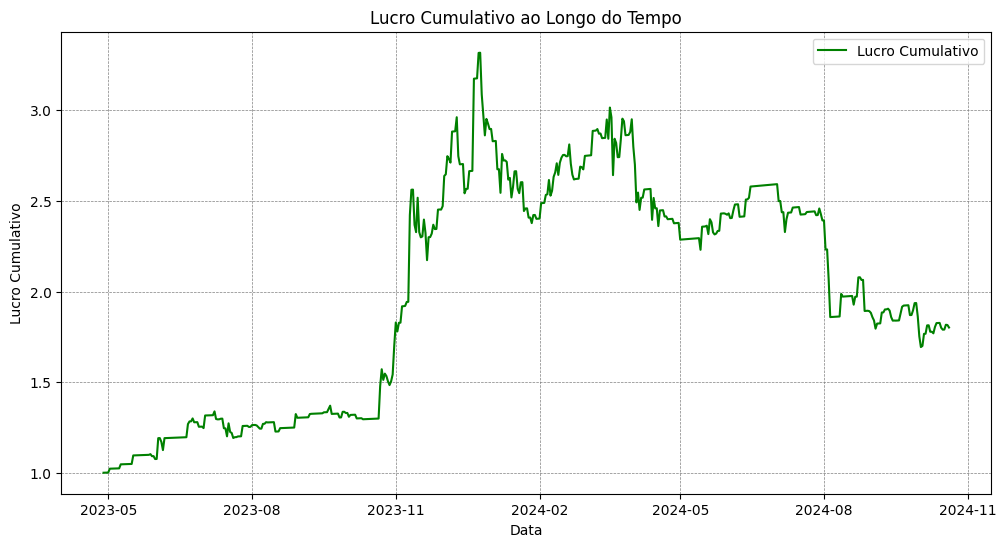

In [40]:
import matplotlib.dates as mdates
df_profit.index = pd.to_datetime(df_profit.index)
# Calcula o produto cumulativo dos valores na coluna de lucro
df_profit['cumulative_profit'] = df_profit[0].cumprod()

# Define o tamanho do gráfico (opcional)
plt.figure(figsize=(12, 6))

# Plota a série temporal do lucro cumulativo
plt.plot(df_profit.index, df_profit['cumulative_profit'], label="Lucro Cumulativo", color='green')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Exibe uma data por mês
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Exibe no formato Ano-Mês
# Personaliza o gráfico
plt.title("Lucro Cumulativo ao Longo do Tempo")
plt.xlabel("Data")
plt.ylabel("Lucro Cumulativo")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')  # `which='both'` adiciona a grade principal 
#plt.savefig("lucro_cumulativo_ajustado_23-04-28_com_restricao.png", format="png", dpi=300, bbox_inches="tight")  # Salva em alta resolução com bordas ajustadas
# Exibe o gráfico
plt.show()



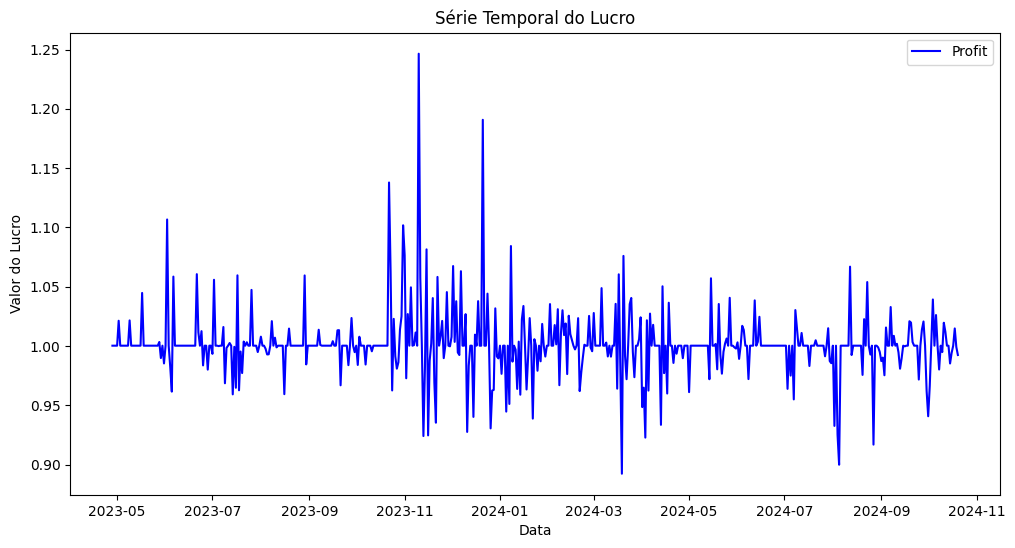

In [41]:
# Define o tamanho do gráfico (opcional)
plt.figure(figsize=(12, 6))

# Plota a série temporal
plt.plot(df_profit.index, df_profit[0], label="Profit", color='blue')

# Personaliza o gráfico
plt.title("Série Temporal do Lucro")
plt.xlabel("Data")
plt.ylabel("Valor do Lucro")
plt.legend()
#plt.savefig("lucro_serie_temporal.png", format="png", dpi=300, bbox_inches="tight")  # Salva em alta resolução com bordas ajustadas
# Exibe o gráfico
plt.show()

In [42]:
df_profit = df_profit.rename(columns={0: "profit"})

In [43]:
df_profit

,profit,cumulative_profit
2023-04-28,1.000300,1.000300
2023-04-29,1.000300,1.000600
2023-04-30,1.000300,1.000900
2023-05-01,1.000300,1.001201
2023-05-02,1.021326,1.022552
...,...,...
2024-10-16,0.994209,1.789631
2024-10-17,1.000300,1.790168
2024-10-18,1.014828,1.816712
2024-10-19,0.999178,1.815219


In [44]:
df_profit.to_csv("df_profit_1.csv")